Notebook Projet Intelligence Artificielle

Mathieu Boudot - Burak Yalcin - Yann Seget - Gabriel Dufour

Demande de l'entreprise : L'entreprise de produits pharmaceutiques HumanForYou basée en Inde emploie environ 4000 personnes. Cependant, chaque année elle subit un turn-over d'environ 15% de ses employés nécessitant de retrouver des profils similaires sur le marché de l'emploi. La direction fait donc appel à des spécialistes de l'analyse de données, pour déterminer les facteurs ayant le plus d'influence sur ce taux de turn-over et lui proposer des modèles afin d'avoir des pistes d'amélioration pour donner à leurs employés l'envie de rester.

# 1. Data Preprocessing

La première étape consiste à nettoyer et transformer les fichiers que nous avons reçus afin de les rendre exploitables par notre modèle.
Voici un descriptif de différents csv à notre disposition :

- **general_data.csv** : Informations concernant les employés.
- **manager_survey_data.csv** : Evaluation de chaque employé fait par son manager.
- **employee_survey_data.csv** : Enquête qualité de vie au travail.
- **in_time.csv/out_time.csv** : Horaires de travail.

Il faut ensuite les fusionner pour obtenir un DataFrame exploitable par notre algorithme.

## 1.1 Détection d'anomalies

Avant l'exploitation de nos données, il est nécessaire de passer par une phase d'analyse des fichiers et énumération des anomalies dans leur contenu. Certaines anomalies sont communes à tous les fichiers commes les doublons et les attributs manquants, tandis que d'autres sont propres à chaque fichier.

**Anomalies rencontrées :**
- Doublons.
- Attributs manquants.
- Attributs similaires sur toute une colonne.
- Attributs non numériques.
- Données aberrantes.

**Import des librairies**

In [27]:
import pandas as pd
import numpy as np
import warnings
import matplotlib
import matplotlib.pyplot as plt

**Import des données**

In [18]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
warnings.filterwarnings('ignore')

gd = pd.read_csv("./data/general_data.csv")
esd = pd.read_csv("./data/employee_survey_data.csv")
msd = pd.read_csv("./data/manager_survey_data.csv")
in_time = pd.read_csv("./data/in_time.csv")
out_time = pd.read_csv("./data/out_time.csv")

**Transformation des données de temps**

Les données de temps ne sont pas exploitables dans l'état actuel des choses.

Notre objectif est d'obtenir la __moyenne du temps de travail par employé__

Différents points d'attentions : 

* Les dates sont stockées en tant que chaine de caractère et ne sont donc pas exploitables
* Certaines données ne sont pas renseignées (NaN), représentant une absence au travail

Il nous faut donc transformer les dates en objet __datetime__ afin de pouvoir executer des opérations.

Le temps moyen d'un utilisateur au travail lorsqu'il est absent étant de 0, nous pouvons remplacer les NaN par 0.

In [19]:
# Convert in_time and out_time into time type so that we can operate on them
def df_to_time_sheet(df: pd.DataFrame):
    df = df.copy()
    df.rename(columns={df.columns[0]: "EmployeeID"}, inplace=True)
    df.dropna(axis=1, how='all', inplace=True)

    for date in df.columns[1:]:
        df[date] = pd.to_datetime(df[date], errors='ignore', format='%Y-%m-%d %H:%M:%S')

    return df

in_time_sheet = df_to_time_sheet(in_time)
out_time_sheet = df_to_time_sheet(out_time)

work_time_sheet = pd.DataFrame()
work_time_sheet.insert(0, column="EmployeeID", value=in_time_sheet[in_time_sheet.columns[0]])

# Calculate the defference between the in time and the out time
for date in in_time_sheet.columns[1:]:
    work_time_sheet.insert(len(work_time_sheet.columns), column=date, value=out_time_sheet[date] - in_time_sheet[date])

work_time_sheet.fillna(value=pd.Timedelta(value=0), inplace=True)

Supression des colonnes représentant l'ID des employés qui n'est pas pertinent pour notre objectif

In [20]:
work_time_sheet.drop(columns="EmployeeID", axis=1).mean(axis=0).head()

2015-01-02   0 days 07:20:07.132199546
2015-01-05   0 days 07:20:39.975510204
2015-01-06   0 days 07:18:32.955102040
2015-01-07   0 days 07:20:33.236054421
2015-01-08   0 days 07:17:07.187528344
dtype: timedelta64[ns]

Fusion de nos différents jeux de données

In [21]:
# Merging main dataset with the work time sheet and surveys

main_dataset = gd.copy()
main_dataset = main_dataset.merge(esd, how='left', on='EmployeeID')
main_dataset = main_dataset.merge(msd, how='left', on='EmployeeID')
main_dataset = main_dataset.merge(work_time_sheet,  how='left', on='EmployeeID')
main_dataset.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-15,2015-01-16,2015-01-19,2015-01-20,2015-01-21,2015-01-22,2015-01-23,2015-01-27,2015-01-28,2015-01-29,2015-01-30,2015-02-02,2015-02-03,2015-02-04,2015-02-05,2015-02-06,2015-02-09,2015-02-10,2015-02-11,2015-02-12,2015-02-13,2015-02-16,2015-02-17,2015-02-18,2015-02-19,2015-02-20,2015-02-23,2015-02-24,2015-02-25,2015-02-26,2015-02-27,2015-03-02,2015-03-03,2015-03-04,2015-03-06,2015-03-09,2015-03-10,2015-03-11,2015-03-12,2015-03-13,2015-03-16,2015-03-17,2015-03-18,2015-03-19,2015-03-20,2015-03-23,2015-03-24,2015-03-25,2015-03-26,2015-03-27,2015-03-30,2015-03-31,2015-04-01,2015-04-02,2015-04-03,2015-04-06,2015-04-07,2015-04-08,2015-04-09,2015-04-10,2015-04-13,2015-04-14,2015-04-15,2015-04-16,2015-04-17,2015-04-20,2015-04-21,2015-04-22,2015-04-23,2015-04-24,2015-04-27,2015-04-28,2015-04-29,2015-04-30,2015-05-04,2015-05-05,2015-05-06,2015-05-07,2015-05-08,2015-05-11,2015-05-12,2015-05-13,2015-05-14,2015-05-15,2015-05-18,2015-05-19,2015-05-20,2015-05-21,2015-05-22,2015-05-25,2015-05-26,2015-05-27,2015-05-28,2015-05-29,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-08,2015-06-09,2015-06-10,2015-06-11,2015-06-12,2015-06-15,2015-06-16,2015-06-17,2015-06-18,2015-06-19,2015-06-22,2015-06-23,2015-06-24,2015-06-25,2015-06-26,2015-06-29,2015-06-30,2015-07-01,2015-07-02,2015-07-03,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-14,2015-09-15,2015-09-16,2015-09-18,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-12,2015-11-13,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,1,Healthcare Representative,Married,131160,1.0,Y,11,8,0,1.0,6,1,0,0,3.0,4.0,2.0,3,3,0 days 07:12:30,0 days 07:11:23,0 days 07:24:39,0 days 07:00:24,0 days 07:17:23,0 days 07:29:04,0 days 07:15:46,0 days 07:49:52,0 days 07:20:49,0 days 07:16:03,0 days 00:00:00,0 days 06:46:33,0 days 07:05:42,0 days 07:03:02,0 days 07:36:17,0 days 07:37:45,0 days 07:07:08,0 days 07:24:49,0 days 06:50:59,0 days 06:54:06,0 days 07:12:11,0 days 07:36:19,0 days 07:33:55,0 days 07:28:12,0 days 07:36:05,0 days 07:16:02,0 days 07:11:35,0 days 07:26:07,0 days 07:12:19,0 days 07:36:21,0 days 07:24:58,0 days 07:50:23,0 days 00:00:00,0 days 07:49:56,0 days 07:26:28,0 days 07:13:30,0 days 07:35:01,0 days 07:12:03,0 days 07:23:09,0 days 07:09:25,0 days 06:45:35,0 days 07:44:40,0 days 07:48:54,0 days 0

Choix des données à garder

Justifications etc..

In [24]:
data = gd.copy()
data.join(esd, rsuffix="_esd")
data.join(msd, rsuffix="_msd")
data.drop("EmployeeCount", "EmployeeID", "Over18", "StandardHours", axis=1, inplace=True)

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='median')),
      ('scaler', StandardScaler())])

ohe = OneHotEncoder(handle_unknown='ignore')

categorical_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
      ('onehot', ohe)])

preprocessor = ColumnTransformer(
      transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
)

# Create the pipeline for preprossessing and classifying
data_prepared = preprocessor.fit_transform(data)

In [26]:
data2 = data.loc[:, categorical_features]
data3 = data.loc[:, numeric_features]
data2_prepared = pd.get_dummies(data2)

data4 = data2_prepared.join(data3)
cor_att = data4.corr()[:1]

cor_att.where(abs(cor_att) > 0.05, inplace=True)
cor_att.dropna(inplace=True, axis=1)
cor_att.head()

,Attrition_No,Attrition_Yes,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,Department_Human Resources,EducationField_Human Resources,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Age,TotalWorkingYears,YearsAtCompany,YearsWithCurrManager
Attrition_No,1.0,-1.0,0.074457,-0.115143,-0.080768,-0.091573,0.087716,0.090984,-0.175419,0.159205,0.170338,0.134392,0.156199


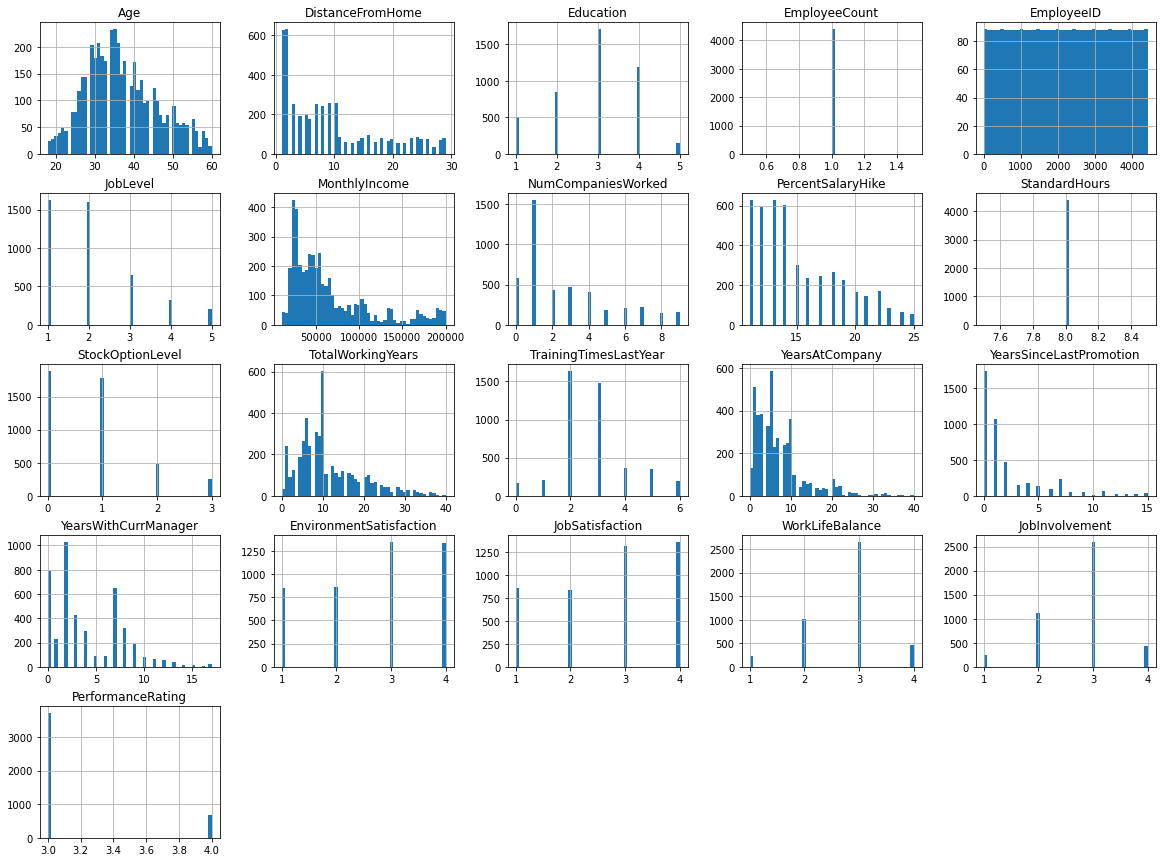

In [29]:
main_dataset.hist(bins=50, figsize=(20,15))
plt.show()